# Cross Validation Methods 

In the Predicting House Prices with Linear Regression project, I talked a little bit about model evaluation. Specifically, I talked about cross validation. I want to expand on this topic.



Let's assume this dataset has been fully cleaned and processed. We are interested in using a linear regression model on this dataset. However, we need a way to evaluate this model's performance.

Specifically, we need to know how well this model will perform with new data. The best way to investigate this idea is to use an example. I've exported my previous project into csv file named "AmesHousinFinal.csv". 

Starting with imports and a brief look at the dataset:

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold


data = pd.read_csv("AmesHousingFinal.csv")
print(data.shape)
data.head()

(1570, 87)


,SalePrice,Overall Qual,Gr Liv Area,Garage Cars,Garage Area,years_to_sell,Total Bsmt SF,1st Flr SF,Full Bath,Garage Yr Blt,...,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS SubClass_120,MS SubClass_160,MS SubClass_180,MS SubClass_190
0,215000,6,1656,2.0,528.0,50,1080.0,1656,1,1960.0,...,0,0,0,0,0,0,0,0,0,0
1,105000,5,896,1.0,730.0,49,882.0,896,1,1961.0,...,0,0,0,0,0,0,0,0,0,0
2,172000,6,1329,1.0,312.0,52,1329.0,1329,1,1958.0,...,0,0,0,0,0,0,0,0,0,0
3,244000,7,2110,2.0,522.0,42,2110.0,2110,2,1968.0,...,0,0,0,0,0,0,0,0,0,0
4,195500,6,1604,2.0,470.0,12,926.0,926,2,1998.0,...,1,0,0,0,0,0,0,0,0,0


### Method 1: Holdout Validation

We are interested in creating a model that can predict the "Sale Price" with the features given in data. The first method is to slice up our dataset into two parts:

+ A training set to fit the model.
+ A testing set to predict our results.

<div style="text-align:center">
<img src = "images/cross-validation/method1.PNG"
alt="holdout validation diagram"/>
</div>

We can then compare the predictions from the testing set with the actual data using RMSE as the error metric.

In [2]:
#93% of the data as training set
train = data[0:1460]
test = data[1460:]
features = data.columns.drop(['SalePrice'])

#train
lr = LinearRegression()
lr.fit(train[features], train['SalePrice'])

#predict
predictions = lr.predict(test[features])
rmse = mean_squared_error(test['SalePrice'], predictions)**0.5
print('RMSE:')
print(rmse)

RMSE:
28749.561761555196


We got ~28749 as our root mean squared error. But can we really use this value as a metric to evaluate our model? 

What happens if we shuffle the dataset arround? We would get a brand new RMSE value!

In [3]:
random_seeds = {}
for i in range(10):
    np.random.seed(i)
    randomed_index = np.random.permutation(data.index)
    randomed_df = data.reindex(randomed_index)

    train = randomed_df[0:1460]
    test = randomed_df[1460:]
    features = randomed_df.columns.drop(['SalePrice'])

    lr = LinearRegression()
    lr.fit(train[features], train['SalePrice'])

    predictions = lr.predict(test[features])
    rmse = mean_squared_error(test['SalePrice'], predictions)**0.5
    random_seeds[i]=rmse
random_seeds

{0: 29156.98404803793,
 1: 29005.494913308787,
 2: 26306.49717295175,
 3: 32018.8213594359,
 4: 31543.21579269828,
 5: 66453.98446604444,
 6: 35640.22774097788,
 7: 34044.8040887492,
 8: 28225.124902220443,
 9: 39500.73574601386}

The output above is a dictionary with random seeds as the keys and RMSE as the values. We are getting drastically different RMSE values depending on how we slice up our data. 

So how do we know if the model is actually good at predicting new data? 

### Method 2: K-Fold Cross Validation

This is where cross validation is really useful. Suppose we split the data set into four blocks (K = 4). We can train four linear regression models with each block being the test set once. The rest of the data will be the training set.

<div style="text-align:center">
<img src = images/cross-validation/Kfold.PNG
alt="K-Fold Cross validation Diagram" style="width:800px;"/>
</div>

Each one of these model will have its own error, in our this case this error will be the RMSE. We can evaluate the model based on the average error from the four models. This method is useful because we are eliminating some of the selection bias. In the first method, only part of the data end up as the training set. In cross validation, all of the data end up in both the training set and the testing set.

In [4]:
kf = KFold(n_splits=4, shuffle=True, random_state = 7)

rmse_list = []
for train_index, test_index in kf.split(data):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    features = data.columns.drop(['SalePrice'])
    
    #train
    lr.fit(train[features], train['SalePrice'])
        
    #predict    
    predictions = lr.predict(test[features])
        
    rmse = mean_squared_error(test['SalePrice'], predictions)**0.5
    rmse_list.append(rmse)
print('RMSE from the four models:')
print(rmse_list)
print('----')
print('Average RMSE:')
print(np.mean(rmse_list))

RMSE from the four models:
[30916.82796137624, 31938.177268887655, 41078.25075425058, 36185.8346785463]
----
Average RMSE:
35029.772665765195


### Method 3: Leave One Out Validation

So what happens if we take K to the extreme, and set K = n. Where n is the number of rows in a dataset. We are going to train n number of models. Each one of these models will have one row as the testing set, and the rest of the data as the training set.

<div style="text-align:center">
<img src = images/cross-validation/leaveoneout.PNG
alt="Leave One Out Validation Diagram" style="width:800px;"/>
</div>


We generate n number of models. Each one of these models will use every single row except for one row as the training set. Then we'll test the model with the row that was not a part of the training set. Finally, we check the error of this model. 

This process gets repeated until all of the rows in our dataset get tested. Once that is complete, we can compute the average error to see how well the model performed.

The biggest drawback to this method is the computation time. We can use the time module from python to determine how long it takes to complete the process.

In [5]:
kf = KFold(n_splits=len(data), shuffle=True, random_state = 7)
rmse_list = []

time_start = time.clock()
for train_index, test_index in kf.split(data):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    features = data.columns.drop(['SalePrice'])
    
    #train
    lr.fit(train[features], train['SalePrice'])
        
    #predict    
    predictions = lr.predict(test[features])
        
    rmse = mean_squared_error(test['SalePrice'], predictions)**0.5
    rmse_list.append(rmse)    
time_stop = time.clock()

print('Processing time:')
print(str(time_stop-time_start) + ' seconds')
print('----')
print('Average RMSE:')
print(np.mean(rmse_list))

Processing time:
15.32140150755418 seconds
----
Average RMSE:
21428.449121978723


It took my computer about 28 seconds to generate 1570 models and computing the error, which isn't so bad. This can get very time consuming/expensive if we had a very large dataset.

### Average RMSE as K approaches n

Let's see what happens if we plot all of this out. I've decided to measure the average RMSE from k=2 to k=1502 at intervals of 100. 

In [6]:
time_start = time.clock()

rmse_kfolds = []
for i in range(2, len(data),100):
    kf = KFold(n_splits=i, shuffle=True, random_state = 7)
    rmse_list = []
    for train_index, test_index in kf.split(data):
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        features = data.columns.drop(['SalePrice'])
    
        #train
        lr.fit(train[features], train['SalePrice'])
        
        #predict    
        predictions = lr.predict(test[features])
        
        rmse = mean_squared_error(test['SalePrice'], predictions)**0.5
        rmse_list.append(rmse)
    rmse_kfolds.append(np.mean(rmse_list))
time_stop = time.clock()

print('Processing time:')
print(str(time_stop-time_start) + ' seconds')



Processing time:
125.91830799470496 seconds


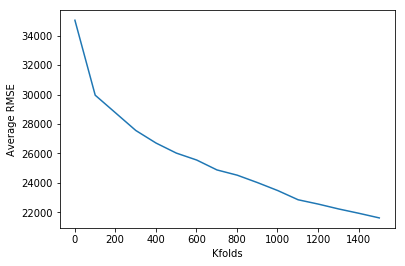

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

x = [i for i in range(2, len(data),100)]
y = rmse_kfolds 
plt.plot(x, y)
plt.xlabel('Kfolds')
plt.ylabel('Average RMSE')
plt.show()

### The Verdict

As we increase the number of Kfolds, the average RMSE goes down. Does that mean we should maximize the number of KFolds each time? No!

Cross validation is a model evaluation technique. We use different estimators such as linear regression, KNN, random forests etc. Then we evaluate the error on each estimator. 

With a small number of KFolds, such as K = 2:
+ Computation time will be low
+ Variance of the estimator will be low
+ Bias of the estimator will be high (underfitting)

With a large number of KFolds as K approachs n:
+ Computation time will be high
+ Bias of the estimator will be low
+ Variance of the estimator will be high (overfitting)

While the computational time is a concern, it is not the only thing we should worry about. For K = n, all the models will be similar, because we are only leaving one row out of the training set. This is great for lowering selection bias. Even though we generated n number of models, it is possible for all these models to be highly inaccurate. For more information on bias/variance click [here](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) for the wikipedia page.

To further explore this idea, let's take a look at what happens when we test our linear regression model with the same data as the training set.

In [8]:
#100% of the data as training set
train = data

#100% of the data as the test set
test = data

features = data.columns.drop(['SalePrice'])

#train
lr = LinearRegression()
lr.fit(train[features], train['SalePrice'])

#predict
predictions = lr.predict(test[features])
rmse = mean_squared_error(test['SalePrice'], predictions)**0.5
print('RMSE:')
print(rmse)

RMSE:
30506.455820900163


If we use the same data for both the testing set and the training set, overfitting is a problem. As a result, this model is specific to the dataset. We got a RMSE value of 30506.

We got an average RMSE value of 21428 from the leave one out validation method. So it is pretty clear that overfitting is an even greater problem in this case.

In practice, the number of folds we should use depends on the dataset. If we have a small dataset, say ~500 rows and we use K = 2. The models will only have 250 rows as the training set. If we have a large dataset, say ~500,000 rows then using K = 2 might be acceptable.

Most academic research papers use K = 10, but keep in mind their datasets are generally small. If we are working with big data, computation time becomes a problem. If that is the case, we should consider using a lower K value.